In [22]:
import networkx as nx
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import time

In [2]:
def watts_strogatz(n,k):
    # Creates a watts-strogatz graph with 
    # node count = n
    # clockwise edges = k (k*2 = degree)
    x = [i for i in range(n)]
    y = [list(x[i+1:])+list(x[:i+1]) for i in range(k)]
    G = nx.Graph()
    for ylist in y:
        [G.add_edge(x[i], ylist[i]) for i in range(len(x))]
    return G


def rewire_graph(G, r, limit):
    # Rewires a graph such that degree is perfectly preserved
    # and contains an error-catch that will attempt up to `limit`
    # `G` is an networkx.Graph object
    # `r` is a rate (0<r<1) of edges to rewire
    # `limit` is an integer cap on iterations to attempt wiring
    # Returns `G`

    edges = list(G.edges)
    i,j = [i[0] for i in edges], [i[1] for i in edges]
    gdf = pd.DataFrame({'i':i, 'j':j})
    gdf['r'] = np.random.rand(len(gdf))
    rewire_df = gdf[gdf['r']<r].copy()
    skip_hist = [1]

    while skip_hist[-1] > 0:
        skipped, gdf = find_pairs(rewire_df, gdf)
        gdf['r'] = np.random.rand(len(gdf))
        gdf = gdf.sort_values('r')
        rewire_df = gdf.head(skipped)
        gdf = gdf.sort_index()
        if len(skip_hist) > limit:
            skip_hist.append(0)
        else:
            skip_hist.append(skipped)

    G = nx.Graph()
    i,j = gdf['i'].tolist(), gdf['j'].tolist()

    for idx in range(len(i)):
        G.add_edge(i[idx], j[idx])
    return G
    

def find_pairs(rewire_df, gdf):
    skipped = 0
    for idx, row in rewire_df.iterrows():
        i,j = int(row['i']), int(row['j'])
        filter = gdf[(gdf['i']==i) | (gdf['j']==j)]
        cand = gdf[   (~gdf['i'].isin(filter['i'])) \
                    & (~gdf['i'].isin(filter['j']))  \
                    & (~gdf['j'].isin(filter['j']))  \
                    & (~gdf['j'].isin(filter['i']))]
        if len(cand) > 0:
            select = np.random.choice(cand.index.tolist())
            cand_row = cand.loc[select]
            h, k = cand_row['i'], cand_row['j']
            r = random.random()
            ni, nj = i, h if r > 0.5 else k
            nh, nk = j, k if r > 0.5 else h
            ij, hk = sorted([ni, nj]), sorted([nh, nk])
            gdf.loc[idx: idx, 'i':'j'] = ij[0], ij[1]
            gdf.loc[cand_row.name:cand_row.name, 'i':'j'] = hk[0], hk[1] 
        else:
            skipped += 1
    return skipped, gdf




In [16]:
def display_histogram(G):
    e = sum([len(G.edges(i)) for i in G.nodes()])
    plt.hist(e)
    plt.show()

In [21]:
n, k = 1000,2
G = watts_strogatz(n, k)
#nx.draw_networkx(G)
#plt.show()
#display_histogram(G)

G = rewire_graph(G, 0.20, 10)

#nx.draw_networkx(G)
#plt.show()
#display_histogram(G)

In [55]:
x, y = [],[]

for i in range(4, 12):
    # Reminder: 
    # k is unidirectional in watts strogatz here.
    # Actual degree = k*2
    n, k, r = 2**i, 2, 0.2 
    G = watts_strogatz(n, k)
    t0 = time.time()
    G = rewire_graph(G, r, 10)
    t1 = time.time()
    x.append(n)
    y.append(t1-t0)

Text(0, 0.5, 'Time (s) (in grey)')

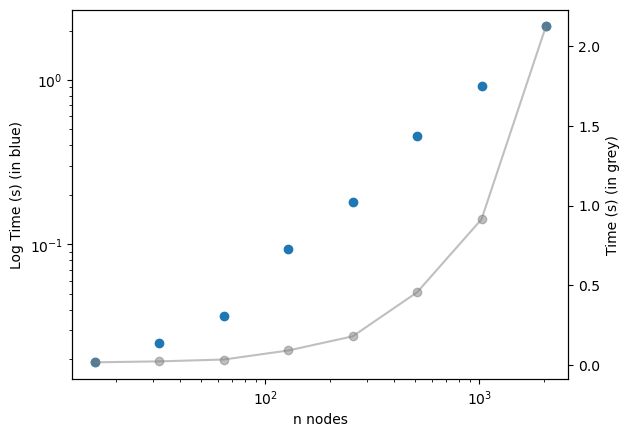

In [56]:
plt.scatter(x,y)
plt.ylabel('Log Time (s) (in blue)')
plt.xlabel('n nodes')
plt.yscale('log')
plt.xscale('log')

ax2 = plt.twinx()
ax2.scatter(x,y, c='grey', alpha=0.5)
ax2.plot(x,y, c='grey', alpha=0.5)
ax2.set_yscale('linear')
ax2.set_ylabel('Time (s) (in grey)')

In [53]:
x, y = [],[]

for i in range(1,21):
    n, k, r = 1000, 2, (i/100)*2 # k is unidirectional in watts strogatz here: actual degree = k*2
    G = watts_strogatz(n, k)
    t0 = time.time()
    G = rewire_graph(G, r, 10)
    t1 = time.time()
    x.append(r)
    y.append(t1-t0)

Text(0, 0.5, 'Time (s) (in grey)')

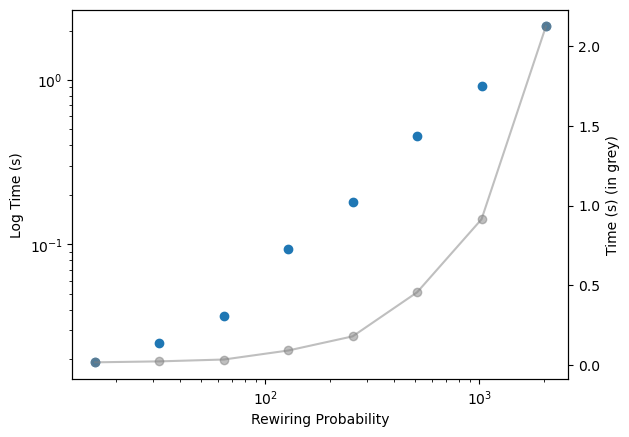

In [58]:
plt.scatter(x,y)
plt.ylabel('Log Time (s)')
plt.xlabel('Rewiring Probability')
plt.yscale('log')
plt.xscale('log')

ax2 = plt.twinx()
ax2.scatter(x,y, c='grey', alpha=0.5)
ax2.plot(x,y, c='grey', alpha=0.5)
ax2.set_yscale('linear')
ax2.set_ylabel('Time (s) (in grey)')